<a href="https://colab.research.google.com/github/SnitikaDash/Data-Science-Projects/blob/main/Project_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset columns: Index(['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate',
       'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID',
       'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration',
       'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate'],
      dtype='object')


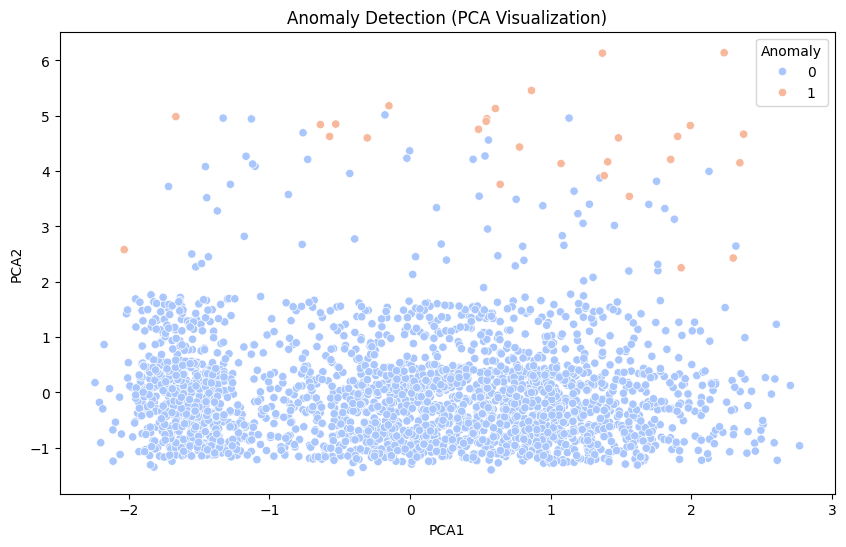

<ipython-input-1-d5c4fadb668a>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='is_anomaly', palette='Set2')


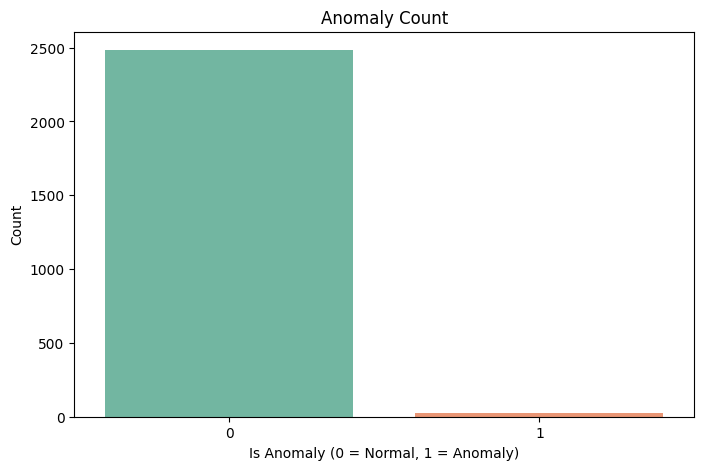

Anomalies detected:
     TransactionID AccountID  TransactionAmount      TransactionDate  \
274       TX000275   AC00454            1176.28  2023-12-20 16:08:02   
394       TX000395   AC00326               6.30  2023-12-14 18:52:54   
454       TX000455   AC00264             611.11  2023-10-18 18:32:31   
463       TX000464   AC00417             302.16  2023-10-18 17:47:52   
491       TX000492   AC00318             505.19  2023-03-14 16:25:04   
691       TX000692   AC00418              25.94  2023-10-16 18:53:31   
693       TX000694   AC00011             733.29  2023-03-15 18:42:16   
772       TX000773   AC00093             827.14  2023-01-17 17:25:13   
807       TX000808   AC00316             668.67  2023-11-07 17:38:05   
837       TX000838   AC00169              39.21  2023-05-10 16:15:31   
898       TX000899   AC00083            1531.31  2023-10-23 18:00:29   
953       TX000954   AC00187             119.95  2023-04-10 17:53:04   
1057      TX001058   AC00191              83

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Step 1: Load the CSV file
file_path = "bank_transactions_data_2.csv"
try:
    data = pd.read_csv(file_path)
except Exception as e:
    print(f"Error loading file: {e}")
    exit()

# Display the dataset's columns for verification
print("Dataset columns:", data.columns)

# Step 2: Data Preprocessing
# Drop 'Index' and 'Address' columns if they exist
drop_columns = [col for col in ['Index', 'Address'] if col in data.columns]
if drop_columns:
    print(f"Dropping columns: {drop_columns}")
    data = data.drop(columns=drop_columns)

# Handle missing values
data = data.fillna(data.mean(numeric_only=True))

# Step 3: Feature Engineering
# Adding a feature for transaction amounts scaled by historical mean
if 'Transaction_Amount' in data.columns:
    data['Transaction_Amount_Scaled'] = data['Transaction_Amount'] / data['Transaction_Amount'].mean()

# Adding time-based features if 'Transaction_Date' exists
if 'Transaction_Date' in data.columns:
    try:
        data['Transaction_Date'] = pd.to_datetime(data['Transaction_Date'], errors='coerce')
        data['Day_of_Week'] = data['Transaction_Date'].dt.dayofweek
        data['Hour_of_Day'] = data['Transaction_Date'].dt.hour
    except Exception as e:
        print(f"Error parsing dates: {e}")

# Adding interaction terms
if 'Balance' in data.columns and 'Transaction_Amount' in data.columns:
    data['Balance_to_Transaction_Ratio'] = data['Balance'] / data['Transaction_Amount']

# Select numerical features for scaling and modeling
numerical_features = data.select_dtypes(include=[np.number])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(numerical_features)

# Step 4: Model Training
# Split data for evaluation
X_train, X_test = train_test_split(features_scaled, test_size=0.2, random_state=42)

# Train Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(X_train)

# Step 5: Prediction
# Predict anomalies
predictions = model.predict(features_scaled)
data['is_anomaly'] = pd.Series(predictions).apply(lambda x: 1 if x == -1 else 0)

# Step 6: Visualization
# PCA visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='is_anomaly', palette='coolwarm')
plt.title('Anomaly Detection (PCA Visualization)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Anomaly', loc='best')
plt.show()

# Histogram of anomalies
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='is_anomaly', palette='Set2')
plt.title('Anomaly Count')
plt.xlabel('Is Anomaly (0 = Normal, 1 = Anomaly)')
plt.ylabel('Count')
plt.show()

# Time-series visualization
if 'Transaction_Date' in data.columns:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data, x='Transaction_Date', y='Transaction_Amount', hue='is_anomaly', style='is_anomaly')
    plt.title('Anomaly Detection Over Time')
    plt.xlabel('Date')
    plt.ylabel('Transaction Amount')
    plt.show()

# Step 7: Display the anomalies
print("Anomalies detected:")
print(data[data['is_anomaly'] == 1])


